In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy import stats
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn.decomposition import PCA
import seaborn as sns
sns.set()

Проведем EDA над данными girls from playboy 


In [5]:
# загрузим данные, посмотрим на них
data=pd.read_csv('girls.csv')
data.head()

,Month,Year,Bust,Waist,Hips,Height,Weight
0,December,1953,91,61,91,165,54
1,March,1954,86,61,89,168,54
2,July,1955,91,61,91,166,52
3,December,1955,91,61,91,166,52
4,July,1956,91,61,86,157,48


In [6]:
# оценим отсутсвующие значения
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   604 non-null    object
 1   Year    604 non-null    int64 
 2   Bust    604 non-null    int64 
 3   Waist   604 non-null    int64 
 4   Hips    604 non-null    int64 
 5   Height  604 non-null    int64 
 6   Weight  604 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 33.2+ KB


In [7]:
# посмотрим на уникальные значения по признакам
data.nunique()

Month     12
Year      57
Bust      16
Waist     16
Hips      19
Height    26
Weight    26
dtype: int64

In [8]:
# обратим внимание на "критические" значения, min и max 
data.describe()

,Year,Bust,Waist,Hips,Height,Weight
count,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000
mean,1983.057947,89.293046,59.529801,87.942053,167.887417,52.168874
std,14.843740,3.994011,3.616909,3.479142,5.776711,4.040585
min,1953.000000,81.000000,46.000000,61.000000,150.000000,42.000000
25%,1970.000000,86.000000,58.000000,86.000000,165.000000,49.000000
50%,1983.000000,89.000000,61.000000,89.000000,168.000000,52.000000
75%,1996.000000,91.000000,61.000000,91.000000,173.000000,54.000000
max,2009.000000,104.000000,89.000000,99.000000,188.000000,68.000000


In [9]:
# находим двух девиц со странными параметрами Waist/талия=89 и Hips/бедра=61
data.query('Waist==89 or Hips==61')
#data.query('Hips==61')

,Month,Year,Bust,Waist,Hips,Height,Weight
483,December,1998,86,89,86,173,52
556,January,2005,91,61,61,165,50


Странная история..., мисс декабрь 1998 имеет одинаковые грудь, талию и бедра..., очень на любителя.... У мисс январь 2005 талия и бедра по 61см, в 2005 такие были уже не в моде. Предположим, что в наших данных есть выбросы и попробуем с этим разобраться.

Построим гистограммы для основных признаков, посмотрим на распределения и критические значения

<ipython-input-21-d08f706ab5ab>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


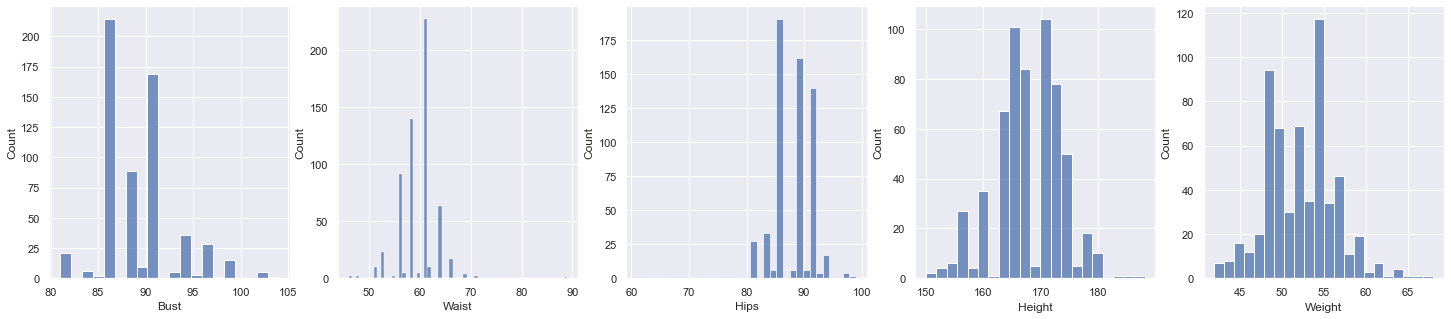

In [21]:
fig, ax =plt.subplots(1,5,figsize=(25,5))
sns.histplot(data["Bust"], ax=ax[0])
sns.histplot(data["Waist"], ax=ax[1])
sns.histplot(data["Hips"], ax=ax[2])
sns.histplot(data["Height"], ax=ax[3])
sns.histplot(data["Weight"], ax=ax[4])
fig.show()

<AxesSubplot:xlabel='Bust', ylabel='Count'>

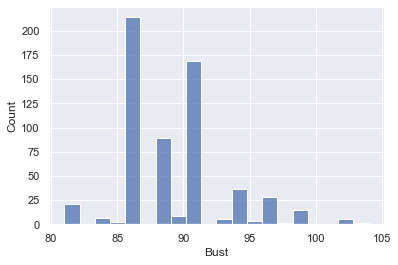

In [22]:
sns.histplot(data.Bust, bins=20)


<AxesSubplot:xlabel='Waist', ylabel='Count'>

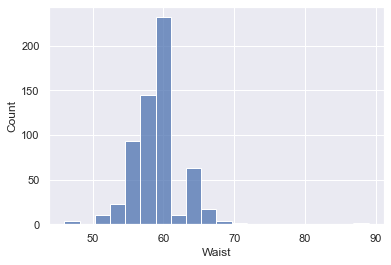

In [23]:
sns.histplot(data.Waist, bins=20)

<AxesSubplot:xlabel='Height', ylabel='Count'>

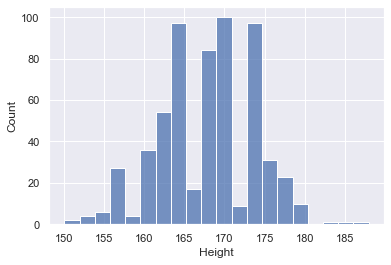

In [26]:
sns.histplot(data.Height, bins=20)

<AxesSubplot:xlabel='Weight', ylabel='Count'>

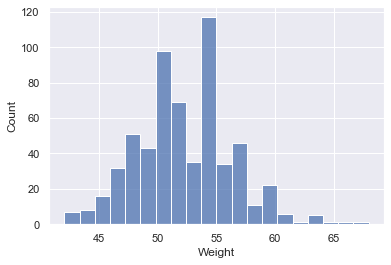

In [25]:
sns.histplot(data.Weight, bins=20)

<AxesSubplot:xlabel='Hips', ylabel='Count'>

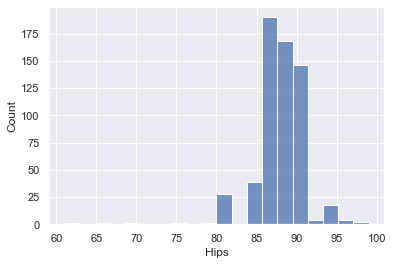

In [27]:
sns.histplot(data.Hips, bins=20)

In [28]:
# для того что бы нормализовать данные переведем их в формат numpy appay
data_np=np.array(data[['Year', 'Bust', 'Waist', 'Hips', 'Height', 'Weight']])
data_np=scale(data_np)

In [29]:
# задаем PCA котрый выделит 2 компоненты
X = PCA(n_components=2).fit_transform(data_np)
# сохраним количество записей/девушек
girls_num = X.shape[0]
# зададим порог, мы ищем 1% аномалий 
OUTLIER_FRACTION = 0.01

In [30]:
# обучим модель
clf = svm.OneClassSVM(kernel="rbf")
clf.fit(X)

OneClassSVM()

Создаем массив dist_to_border, который хранит расстояния от объектов обучающей выборки X до построенной разделяющей поверхности, а затем, после того, как мы выбрали порог, создаем массив индикаторов (True или False) того, что объект является представителем данного класса, а не выбросом. При этом расстояние положительно, если объект лежит «внутри» области, ограниченной построенной разделяющей поверхностью (т.е. является представителем класса), и отрицательно в противном случае. Порог определяется статистически, как такое расстояние до разделяющей поверхности, что у OUTLIER_FRACTION (в нашем случае у одного) процента выборки оно больше (т.е в нашем случае, threshold — это 1%-перцентиль массива расстояний до разделяющей поверхности).

In [31]:
dist_to_border = clf.decision_function(X).ravel()
threshold = stats.scoreatpercentile(dist_to_border,
            100 * OUTLIER_FRACTION)
is_inlier = dist_to_border > threshold

Визуализируем результаты

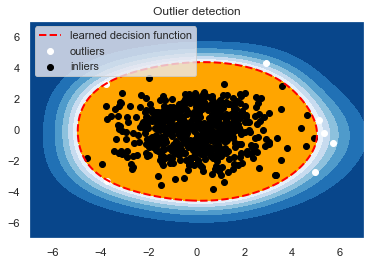

In [32]:
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - OUTLIER_FRACTION) * girls_num)
n_outliers = int(OUTLIER_FRACTION * girls_num)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.title("Outlier detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
b = plt.scatter(X[is_inlier == 0, 0], X[is_inlier == 0, 1], c='white')
c = plt.scatter(X[is_inlier == 1, 0], X[is_inlier == 1, 1], c='black')
plt.axis('tight')
plt.legend([a.collections[0], b, c],
           ['learned decision function', 'outliers', 'inliers'],
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlim((-7, 7))
plt.ylim((-7, 7))
plt.show()

Наблюдаем 7 белых точек/выбросов. Кто эти звезды ???

In [35]:
print (data[is_inlier == 0])

         Month  Year  Bust  Waist  Hips  Height  Weight
54   September  1962    91     46    86     152      45
67     October  1963    94     66    94     183      68
79     October  1964   104     64    97     168      66
173  September  1972    98     64    99     185      64
483   December  1998    86     89    86     173      52
491     August  1999    97     71    97     173      64
556    January  2005    91     61    61     165      50
